## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tifffile as tiff
import cv2
import os
from tqdm.notebook import tqdm
import zipfile
from glob import glob
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('display.max_columns', None)

In [2]:
DATA_PATH = "../input/hubmap-kidney-segmentation"
MASKS = f"{DATA_PATH}/train.csv"
DATA = f"{DATA_PATH}/train/"
TEST_DATA = f"{DATA_PATH}/test/"
SHFT = [0, 0.5]
REDUCE = 4
SIZE = 256
SAT_THR = 40
PIX_THR = 200 * SIZE // 256
NORM = True
BNW = True
TRIPLE = True
PSEUDO = True
EXT = True

if BNW == False:
    TRIPLE = False

TILES_PATH = f"{DATA_PATH}/tiles_r{REDUCE}_s{SIZE}"
MASKS_PATH = f"{DATA_PATH}/masks_R{REDUCE}_s{SIZE}"
if BNW:
    TILES_PATH += "_bnw"
    MASKS_PATH += "_bnw"

if PSEUDO:
    TILES_PATH += f"_pseudo"
    MASKS_PATH += f"_pseudo"
if EXT:
    TILES_PATH += f"_ext"
    MASKS_PATH += f"_ext"
    
PSEUDO_PRED_PATH = "../input/hubmap-kidney-segmentation/submission.csv"

for path in [TILES_PATH, MASKS_PATH]:
    if not os.path.exists(path):
        os.mkdir(path)

In [3]:
if EXT:
    external_images = glob("../input/hubmap-kidney-segmentation/external/images_1024/*")
    for external_image in tqdm(external_images):
        external_mask = external_image.replace("images", "masks")
    
        img_ext = cv2.imread(external_image)
        msk_ext = cv2.imread(external_mask, cv2.IMREAD_GRAYSCALE)

        img_ext = cv2.resize(img_ext, (SIZE, SIZE))
        msk_ext = cv2.resize(msk_ext, (SIZE,SIZE))
        if (msk_ext.mean() == 0) & (np.random.randint(0,2) != 0):
            continue
        if BNW:
            img_ext = cv2.cvtColor(img_ext, cv2.COLOR_BGR2GRAY)
            if img_ext.mean() > 235:
                continue
            img_ext = img_ext * (255 / img_ext.max())
            img_ext[img_ext > 255] = 255
            img_ext = np.round(img_ext).astype(np.uint8)
            img_ext = np.transpose(np.array([img_ext,img_ext,img_ext]), (1,2,0))
        else:
            img_ext = cv2.cvtColor(img_ext, cv2.COLOR_BGR2RGB)
        ext_img_path = external_image.replace("../input/hubmap-kidney-segmentation/external/images_1024", TILES_PATH)
        ext_mask_path = external_mask.replace("../input/hubmap-kidney-segmentation/external/masks_1024", MASKS_PATH)
        is_written = cv2.imwrite(ext_img_path, img_ext)
        if not is_written:
            print("error writing to file ", ext_img_path)
        is_written = cv2.imwrite(ext_mask_path, msk_ext)
        if not is_written:
            print(f"error writing to file {ext_mask_path}")


  0%|          | 0/2575 [00:00<?, ?it/s]

In [4]:
def enc2mask(encs, shape):
    img = np.zeros(shape[0] * shape[1], dtype = np.uint8)
    for m, enc in enumerate(encs):
        if isinstance(enc, np.float) and np.isnan(enc):
            continue
        s = enc.split()
        for i in range(len(s) // 2):
            start = int(s[2 * i]) -1
            length = int(s[2 * i + 1])
            img[start: start + length] = 1 + m
    return img.reshape(shape).T
        

In [5]:
dfs, paths = [], []
dfs.append(pd.read_csv(MASKS).set_index("id"))
paths.append(DATA)

In [6]:
if PSEUDO:
    pseudo_df = pd.read_csv(PSEUDO_PRED_PATH).set_index("id")
    pseudo_df.columns = ["encoding"]
    
    dfs.append(pseudo_df)
    paths.append(TEST_DATA)



In [7]:
for df_masks, data_path in zip(dfs, paths):
    print(df_masks.head())
    print(data_path)

                                                    encoding
id                                                          
2f6ecfcdf  296084587 4 296115835 6 296115859 14 296147109...
8242609fa  96909968 56 96941265 60 96972563 64 97003861 6...
aaa6a05cc  30989109 59 31007591 64 31026074 68 31044556 7...
cb2d976f4  78144363 5 78179297 15 78214231 25 78249165 35...
b9a3865fc  61271840 4 61303134 13 61334428 22 61365722 30...
../input/hubmap-kidney-segmentation/train/
                                                    encoding
id                                                          
2ec3f1bb9  60762268 64 60786258 64 60810248 64 60834238 6...
3589adb90  68423520 36 68452953 36 68482386 36 68511819 3...
57512b7f1  328852843 16 328886083 16 328919323 16 3289525...
aa05346ff  52856673 64 52887393 64 52918113 64 52948833 6...
d488c759a  548108918 36 548155578 36 548202238 36 5482488...
../input/hubmap-kidney-segmentation/test/


In [8]:
for df_masks, data_path in zip(dfs, paths):
    print(f"processing: {data_path}")
    x_tot, x2_tot = [], []
    for ishift, shift in enumerate(SHFT): #index_shift, shift
        for index, encs in tqdm(df_masks.iterrows(), total = len(df_masks), desc = f"shift {ishift}"):
            img = tiff.imread(os.path.join(data_path, index + ".tiff"))
            print("" * 20)
            print(os.path.join(data_path, index + ".tiff"))
            print(f"img shape: {img.shape}")
            if len(img.shape) == 5:
                img = np.transpose(img.squeeze(), (1, 2, 0))
            if img.shape[0] == 3: 
                img = np.transpose(img.squeeze(), (1, 2, 0))
            mask = enc2mask(encs, (img.shape[1], img.shape[0]))
            shape = img.shape
            try:
                print("before pad img shape:", img.shape)
                pad0 = (REDUCE * SIZE - shape[0] % (REDUCE * SIZE)) % (REDUCE * SIZE)
                
                pad1 = (REDUCE * SIZE - shape[1] % (REDUCE * SIZE)) % (REDUCE * SIZE)
                
                img = np.pad(img, 
                             [
                                 [pad0 // 2, pad0 - pad0 // 2],
                                 [pad1 // 2, pad1 - pad1 // 2],
                                 [0, 0]
                             ], constant_values = 0)
                
                img = img[
                    0 + int(REDUCE * SIZE * shift) : img.shape[0] - int(REDUCE * SIZE * shift),
                    0 + int(REDUCE * SIZE * shift) : img.shape[1] - int(REDUCE * SIZE * shift),
                    :]
                
                mask = np.pad(mask,
                              [[pad0 // 2, pad0 - pad0 // 2],
                               [pad1 // 2, pad1 - pad1 // 2]],
                              constant_values = 0)
                
                mask = mask[
                    0 + int(REDUCE * SIZE * shift) : mask.shape[0] - int(REDUCE * SIZE * shift),
                    0 + int(REDUCE * SIZE * shift) : mask.shape[1] - int(REDUCE * SIZE * shift)
                ]
                
                img = cv2.resize(img,
                                 (img.shape[1] // REDUCE, img.shape[0] // REDUCE),
                                 interpolation = cv2.INTER_AREA)
                
                img = img.reshape(img.shape[0] // SIZE, SIZE, img.shape[1] // SIZE, SIZE, 3)
                
                img = img.transpose(0, 2, 1, 3, 4).reshape(-1, SIZE, SIZE, 3)
                
                mask = cv2.resize(mask,
                                  (mask.shape[1] // REDUCE, mask.shape[0] // REDUCE),
                                  interpolation = cv2.INTER_NEAREST)
                
                mask = mask.reshape(mask.shape[0] // SIZE, SIZE, mask.shape[1] // SIZE, SIZE)
                
                mask = mask.transpose(0, 2, 1, 3).reshape(-1, SIZE, SIZE)

                for i, (im, m) in enumerate(zip(img, mask)):
                    if (m.mean() == 0) & (np.random.randint(0,2) != 0):
                        continue
                    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)
                    h, s, v = cv2.split(hsv)
                    if (s > SAT_THR).sum() <= PIX_THR or im.sum() <= PIX_THR:
                        continue
                    
                    x_tot.append((im / 255).reshape(-1, 3).mean(0))
                    x2_tot.append(((im / 255) ** 2).reshape(-1, 3).mean(0))
                    if BNW:
                        im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
                        if im.mean() > 197:
                            continue
                        im = im * (255 / im.max())
                        im[im > 255] = 255
                        im = np.round(im).astype(np.uint8)
                        im = np.transpose(np.array([im,im,im]), (1,2,0))
                    else:
                        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
                        
                    is_written = cv2.imwrite(f"{TILES_PATH}/{index}_{i}_{ishift}.png", im)
                    if not is_written:
                        print("error writing to file ", f"{TILES_PATH}/{index}_{i}_{ishift}.png")
                    is_written = cv2.imwrite(f"{MASKS_PATH}/{index}_{i}_{ishift}.png", m)
                    if not is_written:
                        print(f"error writing to file {MASKS_PATH}/{index}_{i}_{ishift}.png")
            except:
                print("error", shape)
                
    img_avg = np.array(x_tot).mean(0)
    img_std = np.sqrt(np.array(x2_tot).mean(0) - img_avg ** 2)
    print("mean:", img_avg, "| std:", img_std)

processing: ../input/hubmap-kidney-segmentation/train/


shift 0:   0%|          | 0/15 [00:00<?, ?it/s]


../input/hubmap-kidney-segmentation/train/2f6ecfcdf.tiff
img shape: (31278, 25794, 3)
before pad img shape: (31278, 25794, 3)


C:\Users\apist\anaconda3\envs\tfgpu\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.



../input/hubmap-kidney-segmentation/train/8242609fa.tiff
img shape: (31299, 44066, 3)
before pad img shape: (31299, 44066, 3)

../input/hubmap-kidney-segmentation/train/aaa6a05cc.tiff
img shape: (18484, 13013, 3)
before pad img shape: (18484, 13013, 3)

../input/hubmap-kidney-segmentation/train/cb2d976f4.tiff
img shape: (34940, 49548, 3)
before pad img shape: (34940, 49548, 3)

../input/hubmap-kidney-segmentation/train/b9a3865fc.tiff
img shape: (31295, 40429, 3)
before pad img shape: (31295, 40429, 3)

../input/hubmap-kidney-segmentation/train/b2dc8411c.tiff
img shape: (14844, 31262, 3)
before pad img shape: (14844, 31262, 3)

../input/hubmap-kidney-segmentation/train/0486052bb.tiff
img shape: (25784, 34937, 3)
before pad img shape: (25784, 34937, 3)

../input/hubmap-kidney-segmentation/train/e79de561c.tiff
img shape: (1, 1, 3, 16180, 27020)
before pad img shape: (16180, 27020, 3)

../input/hubmap-kidney-segmentation/train/095bf7a1f.tiff
img shape: (3, 38160, 39000)
before pad img sha

shift 1:   0%|          | 0/15 [00:00<?, ?it/s]


../input/hubmap-kidney-segmentation/train/2f6ecfcdf.tiff
img shape: (31278, 25794, 3)
before pad img shape: (31278, 25794, 3)

../input/hubmap-kidney-segmentation/train/8242609fa.tiff
img shape: (31299, 44066, 3)
before pad img shape: (31299, 44066, 3)

../input/hubmap-kidney-segmentation/train/aaa6a05cc.tiff
img shape: (18484, 13013, 3)
before pad img shape: (18484, 13013, 3)

../input/hubmap-kidney-segmentation/train/cb2d976f4.tiff
img shape: (34940, 49548, 3)
before pad img shape: (34940, 49548, 3)

../input/hubmap-kidney-segmentation/train/b9a3865fc.tiff
img shape: (31295, 40429, 3)
before pad img shape: (31295, 40429, 3)

../input/hubmap-kidney-segmentation/train/b2dc8411c.tiff
img shape: (14844, 31262, 3)
before pad img shape: (14844, 31262, 3)

../input/hubmap-kidney-segmentation/train/0486052bb.tiff
img shape: (25784, 34937, 3)
before pad img shape: (25784, 34937, 3)

../input/hubmap-kidney-segmentation/train/e79de561c.tiff
img shape: (1, 1, 3, 16180, 27020)
before pad img sha

shift 0:   0%|          | 0/5 [00:00<?, ?it/s]


../input/hubmap-kidney-segmentation/test/2ec3f1bb9.tiff
img shape: (23990, 47723, 3)
before pad img shape: (23990, 47723, 3)

../input/hubmap-kidney-segmentation/test/3589adb90.tiff
img shape: (29433, 22165, 3)
before pad img shape: (29433, 22165, 3)

../input/hubmap-kidney-segmentation/test/57512b7f1.tiff
img shape: (3, 33240, 43160)
before pad img shape: (33240, 43160, 3)

../input/hubmap-kidney-segmentation/test/aa05346ff.tiff
img shape: (3, 30720, 47340)
before pad img shape: (30720, 47340, 3)

../input/hubmap-kidney-segmentation/test/d488c759a.tiff
img shape: (3, 46660, 29020)
before pad img shape: (46660, 29020, 3)


shift 1:   0%|          | 0/5 [00:00<?, ?it/s]


../input/hubmap-kidney-segmentation/test/2ec3f1bb9.tiff
img shape: (23990, 47723, 3)
before pad img shape: (23990, 47723, 3)

../input/hubmap-kidney-segmentation/test/3589adb90.tiff
img shape: (29433, 22165, 3)
before pad img shape: (29433, 22165, 3)

../input/hubmap-kidney-segmentation/test/57512b7f1.tiff
img shape: (3, 33240, 43160)
before pad img shape: (33240, 43160, 3)

../input/hubmap-kidney-segmentation/test/aa05346ff.tiff
img shape: (3, 30720, 47340)
before pad img shape: (30720, 47340, 3)

../input/hubmap-kidney-segmentation/test/d488c759a.tiff
img shape: (3, 46660, 29020)
before pad img shape: (46660, 29020, 3)
mean: [0.63873086 0.47924995 0.68602079] | std: [0.1513327  0.22312315 0.12844211]


In [9]:
print(len(os.listdir(TILES_PATH)))
print(os.listdir(TILES_PATH)[:10])
print(len(os.listdir(MASKS_PATH)))
print(os.listdir(MASKS_PATH)[:10])
images = set([x[:x.find('_')] for x in os.listdir(TILES_PATH)])
print(images)
images = set([x[:x.find('_')] for x in os.listdir(MASKS_PATH)])
print(images)

18462
['0486052bb_100_0.png', '0486052bb_110_1.png', '0486052bb_111_1.png', '0486052bb_112_1.png', '0486052bb_113_1.png', '0486052bb_114_0.png', '0486052bb_114_1.png', '0486052bb_115_0.png', '0486052bb_115_1.png', '0486052bb_116_0.png']
18462
['0486052bb_100_0.png', '0486052bb_110_1.png', '0486052bb_111_1.png', '0486052bb_112_1.png', '0486052bb_113_1.png', '0486052bb_114_0.png', '0486052bb_114_1.png', '0486052bb_115_0.png', '0486052bb_115_1.png', '0486052bb_116_0.png']
{'8242609fa', 'd488c759a', 'b2dc8411c', '57512b7f1', 'b9a3865fc', '1e2425f28', '2ec3f1bb9', '54f2eec69', 'aaa6a05cc', '4ef6695ce', '3589adb90', 'SESCAM', 'VUHSK', '2f6ecfcdf', 'c68fe75ea', 'cb2d976f4', '095bf7a1f', '26dc41664', '0486052bb', 'afa5e8098', 'SAS', 'aa05346ff', 'e79de561c'}
{'8242609fa', 'd488c759a', 'b2dc8411c', '57512b7f1', 'b9a3865fc', '1e2425f28', '2ec3f1bb9', '54f2eec69', 'aaa6a05cc', '4ef6695ce', '3589adb90', 'SESCAM', 'VUHSK', '2f6ecfcdf', 'c68fe75ea', 'cb2d976f4', '095bf7a1f', '26dc41664', '0486052bb'

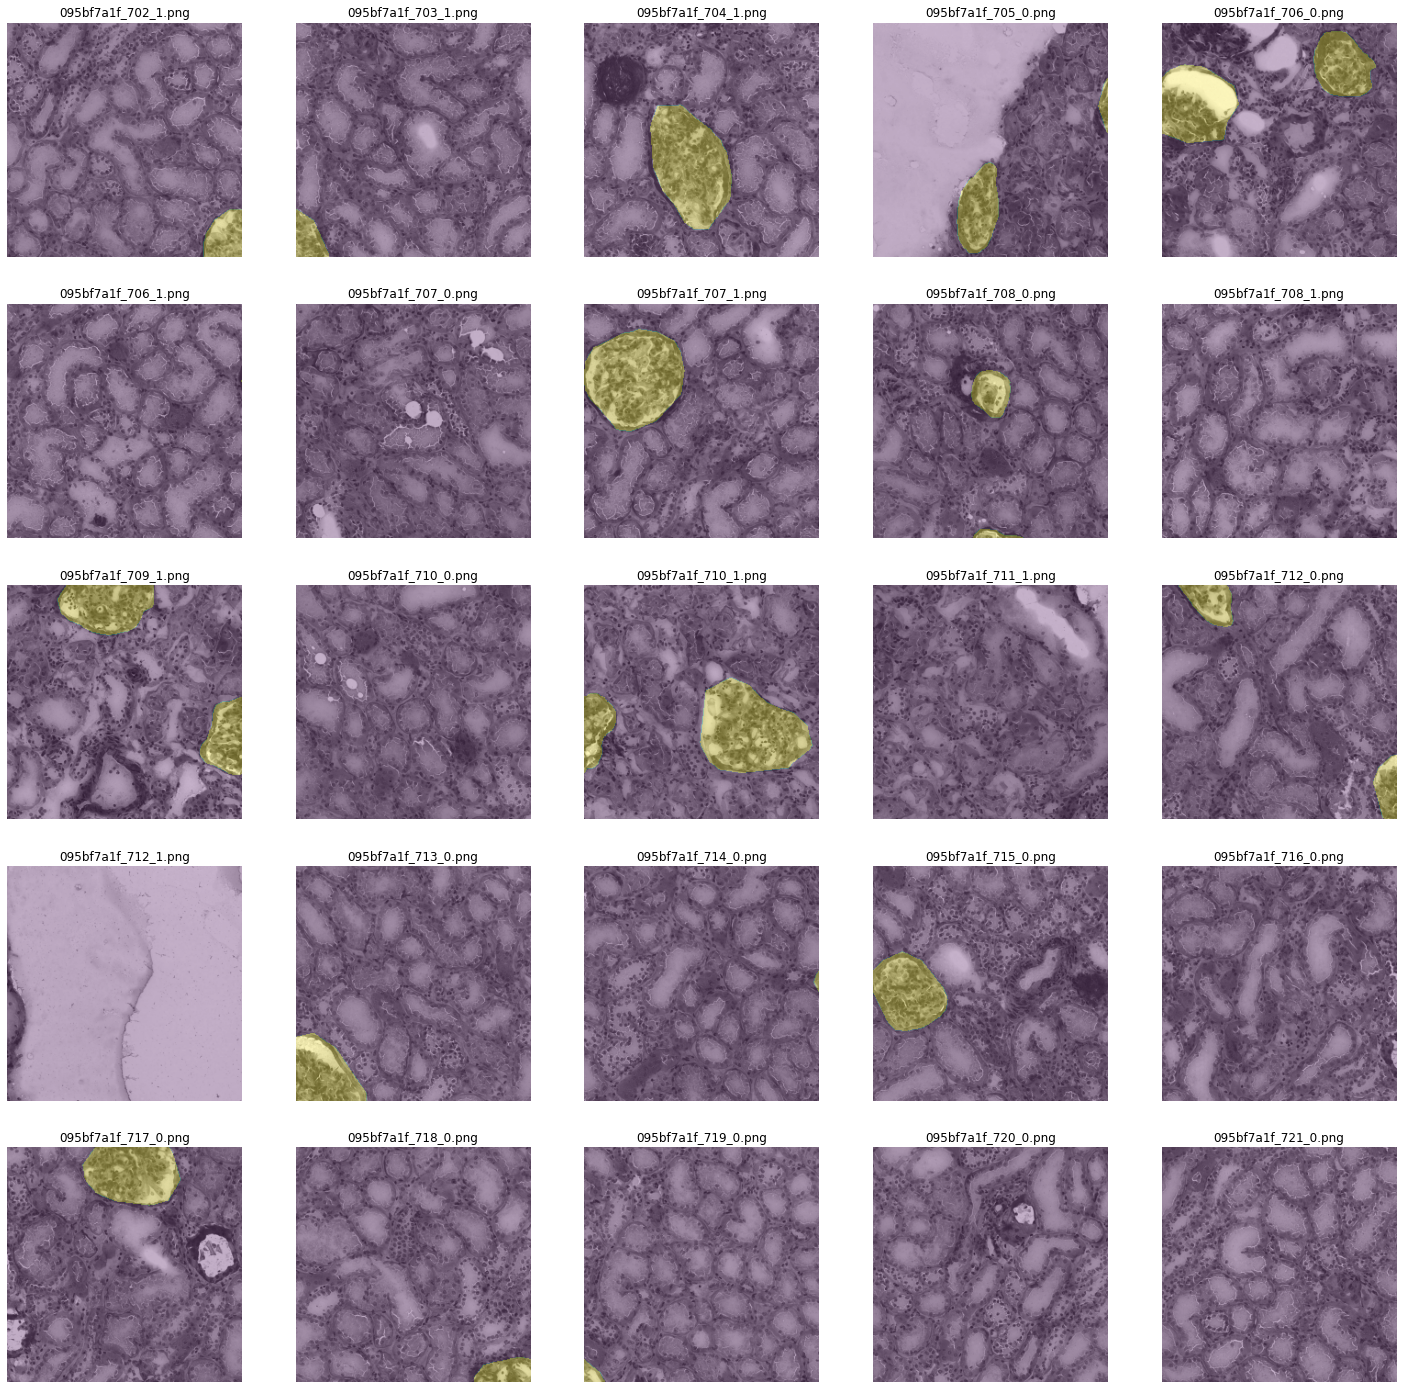

In [10]:
NUM = 5
columns, rows = NUM, NUM
idx0 = 1150
fig = plt.figure(figsize = (columns * NUM, rows * NUM))
fnames = sorted(sorted(os.listdir(TILES_PATH)))
for i in range(rows):
    for j in range(columns):
        idx = i + j * columns
        img = cv2.imread(f'{TILES_PATH}/{fnames[idx0 + idx]}')
        mask = cv2.imread(f'{MASKS_PATH}/{fnames[idx0 + idx]}',
                          cv2.IMREAD_GRAYSCALE)
        fig.add_subplot(rows, columns, idx + 1)
        plt.axis('off')
        plt.imshow(Image.fromarray(img))
        plt.imshow(Image.fromarray(mask), alpha = 0.3)
        plt.title(fnames[idx0 + idx])
plt.show()